In [1]:
import xarray as xr

import numpy as np
import torch
from torch.utils.data import Dataset

from aifs.data.wb_simple_dataset import WeatherBenchSimpleDataset

/perm/syma/conda-envs/shared/gnn-pyg-2.1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cf

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
dset = WeatherBenchSimpleDataset(
        fnames=["/ec/res4/hpcperm/syma/WeatherBench/netcdf/validation-small/val_t_850_1000_v2.nc"],
        var_names=["t"],
        var_mean=xr.load_dataset("/ec/res4/hpcperm/syma/WeatherBench/netcdf/train_mu_v2.nc"),
        var_sd=xr.load_dataset("/ec/res4/hpcperm/syma/WeatherBench/netcdf/train_sd_v2.nc"),
        plevs=[850, 1000],
        lead_time=6,
        rollout=4,
)
dset

[2022-12-14T19:47:00Z] [wb_simple_dataset.py:56 - __init__] [DEBUG] Loading data into RAM ...



            Filenames: ['/ec/res4/hpcperm/syma/WeatherBench/netcdf/validation-small/val_t_850_1000_v2.nc']
            Varnames: ['t']
            Plevs: [850, 1000]
            Lead time: 6
        

In [4]:
for sample_idx, sample in enumerate(dset):
    print(
        f"Sample index: {sample_idx: 02d} -- Sample length: {len(sample)}"
        + f" -- Sample tensor shapes: {[sample[i].shape for i in range(len(sample))]}"
    )
    break

Sample index:  0 -- Sample length: 5 -- Sample tensor shapes: [(65160, 2), (65160, 2), (65160, 2), (65160, 2), (65160, 2)]


In [5]:
X = sample[0]
X.shape

(65160, 2)

In [32]:
ds_xr = xr.open_dataset("/ec/res4/hpcperm/syma/WeatherBench/netcdf/validation-small/val_t_850_1000_v2.nc")
Xt = ds_xr.t.isel(time=0).compute()
Xt

<xarray.DataArray 't' (level: 2, latitude: 181, longitude: 360)>
array([[[234.25903, 234.25903, 234.25903, ..., 234.25903, 234.25903,
         234.25903],
        [235.57544, 235.55786, 235.54224, ..., 235.61841, 235.60474,
         235.58911],
        [238.53638, 238.56177, 238.57935, ..., 238.41333, 238.46411,
         238.50513],
        ...,
        [261.6184 , 261.60864, 261.60083, ..., 261.6477 , 261.63794,
         261.62622],
        [261.35864, 261.3567 , 261.35474, ..., 261.36255, 261.36255,
         261.3606 ],
        [255.98169, 255.98169, 255.98169, ..., 255.98169, 255.98169,
         255.98169]],

       [[241.81367, 241.81367, 241.81367, ..., 241.81367, 241.81367,
         241.81367],
        [243.0832 , 243.06758, 243.05196, ..., 243.12227, 243.11055,
         243.09688],
        [245.85078, 245.88399, 245.90938, ..., 245.71016, 245.76485,
         245.81172],
        ...,
        [266.95428, 266.9875 , 267.01874, ..., 266.84296, 266.88202,
         266.91913],
        [265.3156 , 265.33124, 265.34686, ..., 265.26678, 265.2824 ,
         265.3    ],
        [266.45428, 266.45428, 266.45428, ..., 266.45428, 266.45428,
         266.45428]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * latitude   (latitude) float32 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * level      (level) int32 850 1000
    time       datetime64[ns] 2006-05-19T06:00:00
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

In [33]:
t_mu = xr.load_dataset("/ec/res4/hpcperm/syma/WeatherBench/netcdf/train_mu_v2.nc")
t_sd = xr.load_dataset("/ec/res4/hpcperm/syma/WeatherBench/netcdf/train_sd_v2.nc")

In [34]:
t_mu, t_sd

(<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     t        float32 277.4,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     t        float32 7.124)

In [35]:
Xt_ = (Xt - t_mu) / t_sd
Xt_

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 181, level: 2)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * latitude   (latitude) float32 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * level      (level) int32 850 1000
    time       datetime64[ns] 2006-05-19T06:00:00
Data variables:
    t          (level, latitude, longitude) float32 -6.062 -6.062 ... -1.543

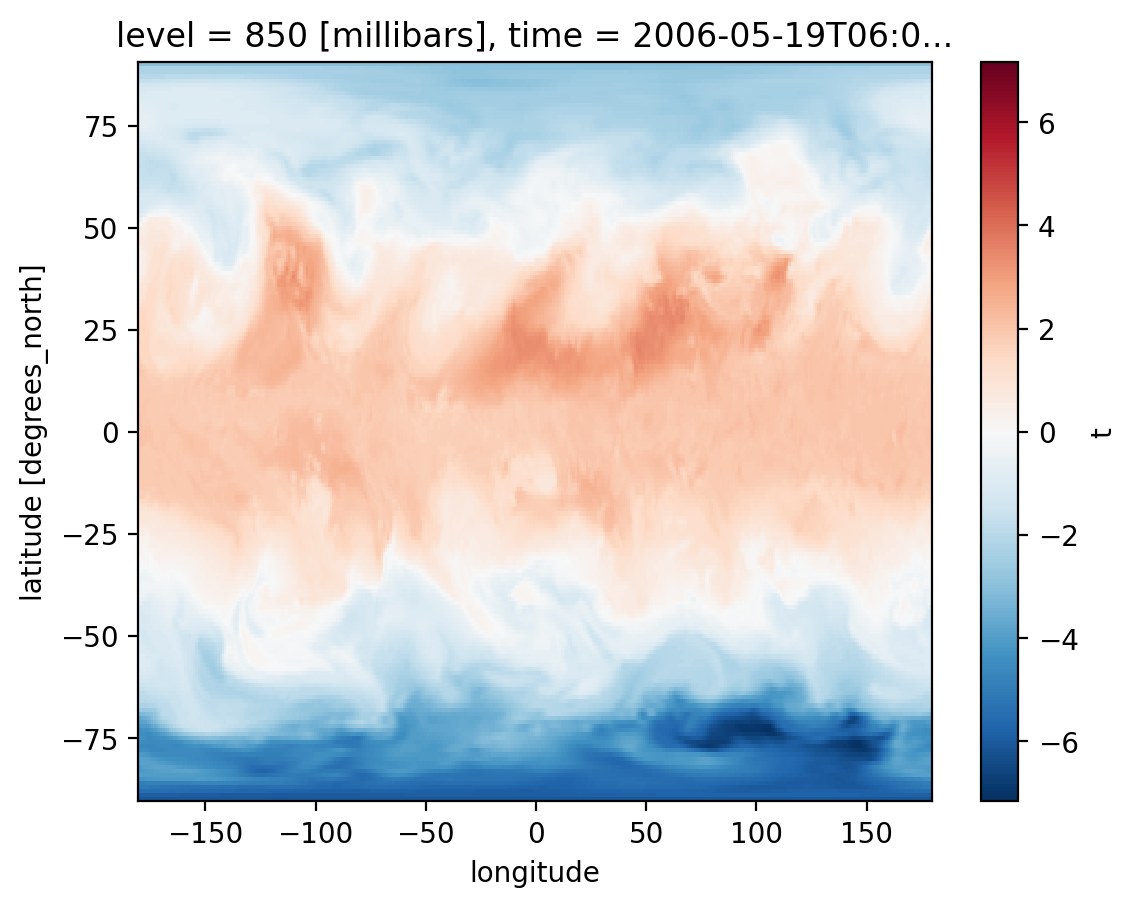

In [36]:
Xt_.t.sel(level=850).plot()

In [37]:
from aifs.data.wb_constants import WeatherBenchConstantFields

const_data = WeatherBenchConstantFields(
    const_fname="/ec/res4/hpcperm/syma/WeatherBench/netcdf/constants.nc",
    const_names=None,
)
const_data

In [38]:
era5_latlons = const_data.era5_latlons
era5_latlons[:10, :]

array([[ -90., -180.],
       [ -90., -179.],
       [ -90., -178.],
       [ -90., -177.],
       [ -90., -176.],
       [ -90., -175.],
       [ -90., -174.],
       [ -90., -173.],
       [ -90., -172.],
       [ -90., -171.]], dtype=float32)

In [39]:
h3_latlons = const_data.h3_latlons
h3_latlons[:10, :]

array([[ -89.24152 , -179.97476 ],
       [ -87.66801 , -179.94176 ],
       [ -87.65343 , -179.90556 ],
       [ -86.91163 , -179.78574 ],
       [ -86.889885, -179.75554 ],
       [ -86.44843 , -179.64105 ],
       [ -86.43907 , -179.6145  ],
       [ -85.632416, -179.52675 ],
       [ -85.12218 , -179.50053 ],
       [ -85.10128 , -179.48169 ]], dtype=float32)

In [40]:
NPTS = 1
X[3462:3462+NPTS, :]

array([[-5.553234 , -4.5039673]], dtype=float32)

In [41]:
era5_latlons[3462:3462+NPTS, :]

array([[-81.,  42.]], dtype=float32)

In [42]:
Xt_.sel(latitude=-81., longitude=42.).t.values

array([-5.553234 , -4.5039673], dtype=float32)